In [1]:
import os
from astropy.table import Table ## to use astropy tables as our data storage and interaction format
import numpy as np

In [2]:
homedir = os.path.expanduser('~')
exe_dir = os.getcwd()
obj_name = "Swift_J0243.6+6124"
obj_prefix = "J0243"
data_dir = '%s/Reduced_data/%s/' % (homedir, obj_name)
assert os.path.isdir(data_dir)

In [3]:
obsid = "1050390113"

### For making a light curve of each FPM detector

In [4]:
detid_bin_file = exe_dir +"/in/detectors.txt"
## Could otherwise use n_chans = detchans FITS keyword in rsp matrix, and
## chan_bins=np.arange(detchans+1)  (need +1 for how histogram does ends)
detID_bins = np.loadtxt(detid_bin_file, dtype=int)

Setting up, assuming same internal file structure as in the FTP download from HEASARC

In [5]:
obs_dir = '%s%s/xti/event_cl/' % (data_dir, obsid)
data_file = '%sni%s_0mpu7_cl.evt' % (obs_dir, obsid)
assert os.path.isfile(data_file), 'Data file does not exist.'

### Reading in event list and gti HDU

In [6]:
datatab = Table.read(data_file, format='fits', hdu=1)
energy_mask = (datatab['PI'] >= 20) & (datatab['PI'] <= 1200)
datatab = datatab[energy_mask]

In [7]:
gtitab = Table.read(data_file, format='fits', hdu=2)

In [8]:
## Initializing
overall_means = np.asarray([])
overall_stds = np.asarray([])
det_means = np.asarray(np.zeros((len(detID_bins)-1,1)))  # -1 because of 0-indexed vs 1-indexed
det_stds = np.asarray(np.zeros((len(detID_bins)-1,1)))

In [9]:
def det_lcs(times, dets, det_bins, gti_start, gti_stop, dt=1):
    """
    times: array of the event list times (arb start, same units as GTI times, in seconds)
    dets: array of the event list FPMs
    gti_start: the start of the GTI (arb start, in seconds)
    gti_stop: the end of the GTI (also in seconds)
    dt: the timestep of the desired lightcurve, in seconds
    """
    n_bins = int(np.round((gti_stop - gti_start) / dt))
    t_bin_seq = np.linspace(gti_start, gti_stop, num=n_bins + 1)
    
    lc_2d, t_bin_edges, d_bin_edges = np.histogram2d(times, dets,
                                                     bins=[t_bin_seq,
                                                           det_bins],
                                                     normed=False)
    ## Need counts/dt to have units of counts per second
    ## Doing it by multiplying by 1/dt, to keep it as an int and not get
    ## typecasting errors.
    dt_inv_int = np.int64(1. / dt)
    lc_2d *= dt_inv_int
    return lc_2d # in units of counts per second

### Looping through the GTIs for the data file

In [10]:
for starttime, stoptime in zip(gtitab['START'], gtitab['STOP']):
    lc = det_lcs(datatab['TIME'],
                 datatab['DET_ID'], 
                 detID_bins, 
                 starttime, 
                 stoptime,
                 dt=0.5)
    print(np.shape(lc))
    overall_means = np.append(overall_means, np.mean(lc))
    overall_stds = np.append(overall_stds, np.std(lc))
    det_means = np.append(det_means, np.mean(lc, axis=0)[:, np.newaxis], axis=1)
    det_stds = np.append(det_stds, np.std(lc, axis=0)[:, np.newaxis], axis=1)
## Removing the zeros i initialized the 2-d arrays with
det_means = det_means[:,1:]
det_stds = det_stds[:,1:]

(1136, 52)
(24, 52)
(708, 52)
(2, 52)
(1705, 52)
(68, 52)
(325, 52)
(2136, 52)
(1874, 52)
(26, 52)


### Determining the upper and lower limits for 'flares' and 'dips' of grumpy FPMs

In [11]:
upper_lim = overall_means + overall_stds
lower_lim = overall_means - overall_stds
# print(upper_lim)
# print(lower_lim)
above = np.where(det_means >= upper_lim)
below = np.where(det_means <= lower_lim)
# print(det_means[above])
flarey_bois = np.unique(detID_bins[above[0]])
print("FLAREY BOIS: ", flarey_bois)
# print(det_means[below])
dippy_bois = np.unique(detID_bins[below[0]])
print("DIPPY BOIS: ", dippy_bois)

FLAREY BOIS:  [27]
DIPPY BOIS:  [61]


### Checking if all the problems are with the same GTIs. If so, throw it out!

In [12]:
## Checking if all the problems are with the same GTIs. If so, throw it out!
print("But wait, is it a GTI issue?")
## Remember that these are zero-indexed, so [3] means the 4th GTI in the list.
print("GTIs with flarey bois: ", np.unique(above[1]))
print("GTIs with dippy bois: ", np.unique(below[1]))

But wait, is it a GTI issue?
GTIs with flarey bois:  [3]
GTIs with dippy bois:  [3]


In [13]:
del datatab
del gtitab

## Running nicerl2
If you identified bad FPMs, remove them here with expr='(DET_ID != XX)'

(nicercal, niextract-events, nimaketime, and nicer-mergeclean with min_fpm=7) to get cleaned event lists

In [14]:
red_script = data_dir+"reduce.sh"
red_log = data_dir+"reduce.log"
local_tot_evt_file = "%s/xti/event_cl/obs%s_0mpu7_cl.evt" % (obsid, obsid[-3:])
local_ci_evt_file = "%s/xti/event_cl/obs%s_0mpu7_CI_cl.evt" % (obsid, obsid[-3:])
with open(red_script, 'w') as f:
#     f.write("rm %s \n" % red_log)
#     f.write("nicerl2 %s clobber=yes > %s\n" % (str(obsid), redlog)) 
#     f.write("fselect infile=./%s/xti/event_cl/ni%s_0mpu7_cl.evt "
#             "outfile=./%s "
#             "clobber=yes > %s\n" % (str(obsid), str(obsid), local_tot_evt_file, red_log))
    f.write("cp ./%s/xti/event_cl/ni%s_0mpu7_cl.evt ./%s \n" % (obsid, obsid, local_tot_evt_file)) 
    f.write("fselect infile=./%s/xti/event_cl/ni%s_0mpu7_cl.evt "
            "outfile=./%s "
            "expr='(DET_ID < 40)' "
            "clobber=yes > %s\n" % (obsid, obsid, local_ci_evt_file, red_log))
print("Run these things at the command line:")
print("bash")
print("heainit")
print("cd %s" % data_dir)
print("chmod u+x %s" % os.path.basename(red_script))
print("./%s" % os.path.basename(red_script))

Run these things at the command line:
bash
heainit
cd /home/astevens/Reduced_data/Swift_J0243.6+6124/
chmod u+x reduce.sh
./reduce.sh


## This next part ensures that we're only making spectra with the exact GTIs we will use for the timing analysis. 

In [15]:
from stingray.events import EventList
from stingray.lightcurve import Lightcurve

/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/fourier.py:18: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crosscorrelation.py:9: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/bispectrum.py:11: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


In [16]:
data_file = '%s%s' % (data_dir, local_tot_evt_file)
print(data_file)
assert os.path.isfile(data_file), 'Data file does not exist.'

/home/astevens/Reduced_data/Swift_J0243.6+6124/1050390113/xti/event_cl/obs113_0mpu7_cl.evt


In [17]:
datatab = Table.read(data_file, format='fits', hdu=1)
print(len(datatab))
energy_mask = (datatab['PI'] >= 20) & (datatab['PI'] <= 1200)
datatab = datatab[energy_mask]
print(len(datatab))
## number should go down, because we're removing events

97159573
97149830


In [18]:
gtitab = Table.read(data_file, format='fits', hdu=2)
print(gtitab)
gtis = [[i,j] for i,j in zip(gtitab['START'], gtitab['STOP'])]

      START               STOP       
        s                  s         
------------------ ------------------
       120970497.0        120971065.0
       120971070.0        120971082.0
       120976288.0        120976642.0
       120992530.0        120992531.0
       120992533.0 120993385.50219412
120993385.50267753 120993419.48035495
120993419.48269826        120993582.0
       121009194.0        121010262.0
       121014748.0        121015685.0
       121015688.0        121015701.0


In [19]:
lc = Lightcurve.make_lightcurve(datatab['TIME'], dt=1./2, gti=gtis)

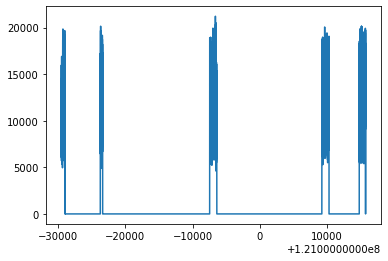

In [20]:
lc.plot()

In [21]:
def meanseg(lc):
    return np.mean(lc.countrate)

In [22]:
n_sec = 64.0
start, stop, meanrate = lc.analyze_lc_chunks(segment_size=n_sec, func=meanseg)
print(len(start))

58


In [23]:
print(meanrate)

[21755.65625  20615.8125   19856.4375   29033.34375  26269.96875
 27682.28125  22261.671875 27186.0625   24859.53125  23778.578125
 23515.875    19742.0625   23646.015625 24062.484375 24619.4375
 24274.40625  19283.234375 21034.578125 21838.0625   22085.34375
 25994.46875  26937.640625 23776.09375  24117.421875 21177.890625
 26517.234375 28726.515625 19138.65625  24927.921875 24190.828125
 21759.828125 20795.171875 23147.03125  24247.640625 25897.84375
 22564.125    22773.53125  26849.375    26612.953125 27806.453125
 25906.671875 21242.96875  23855.65625  24868.09375  22021.75
 25885.515625 25033.65625  27913.53125  28270.75     29848.421875
 23764.34375  22262.125    20120.8125   26349.75     24190.796875
 25004.28125  24565.09375  25875.734375]


In [24]:
print(stop-start)
print(start[1]-start[0])

[64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5
 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5
 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5
 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5 64.5
 64.5 64.5]
64.0


In [25]:
ends = stop-lc.dt
print(np.mean(ends-start))

64.0


If you want to save your segment starts and ends to a text file, uncomment the next block.

In [26]:
# seg_times = np.column_stack((start, ends))
# gti_txt = exe_dir+"/out/%s_%dsec_%ddt_seg-times.txt" % (obj_prefix, n_sec, int(1/lc.dt))
# np.savetxt(gti_txt, seg_times, fmt="%.12f")

Run this at the command line to get a hollow husk of a GTI file 

In [27]:
local_gti_file = "%s/xti/event_cl/obs%s_nobary.gti" % (obsid, obsid[-3:])
print("Run these things at the command line:")
print("bash")
print("heainit")
print("cd %s" % data_dir)
print("nimaketime infile=./%s/auxil/ni%s.mkf outfile=./%s" % (obsid, obsid, local_gti_file))

Run these things at the command line:
bash
heainit
cd /home/astevens/Reduced_data/Swift_J0243.6+6124/
nimaketime infile=./1050390113/auxil/ni1050390113.mkf outfile=./1050390113/xti/event_cl/obs113_nobary.gti


In [28]:
gti_file = "%s%s" % (data_dir, local_gti_file)
assert os.path.isfile(gti_file), 'GTI file does not exist.'

In [29]:
gti2 = Table.read(gti_file, format='fits')
print(gti2)

      START               STOP       
------------------ ------------------
120970497.00001875 120970561.00001875
120970561.00001875 120970625.00001875
120970625.00001875 120970689.00001875
120970689.00001875 120970753.00001875
120970753.00001875 120970817.00001875
120970817.00001875 120970881.00001875
120970881.00001875 120970945.00001875
               ...                ...
121015196.00001875 121015260.00001875
121015260.00001875 121015324.00001875
121015324.00001875 121015388.00001875
121015388.00001875 121015452.00001875
121015452.00001875 121015516.00001875
121015516.00001875 121015580.00001875
121015580.00001875 121015644.00001875
Length = 58 rows


In [30]:
final_tab = Table()
final_tab.meta = gti2.meta

In [31]:
final_tab['START'] = start
final_tab['STOP'] = ends

In [32]:
final_tab.write(gti_file, format='fits', overwrite=True)

In [34]:
del datatab
del gtitab

# Extract the events within just those specific GTIs

In [35]:
extr_script = data_dir+"extract.sh"
extr_log = data_dir+"extract.log"
local_tot_extr_file = "%s/xti/event_cl/obs%s_nobary-extr.evt" % (obsid, obsid[-3:])
local_ci_extr_file = "%s/xti/event_cl/obs%s_CI_nobary-extr.evt" % (obsid, obsid[-3:])
with open(extr_script, 'w') as f:
    f.write("if [ -e %s ]; \n" % extr_log)
    f.write("then rm %s\n" % extr_log)
    f.write("fi \n")
    f.write("niextract-events "
            "filename=./%s[PI=20:1200,EVENT_FLAGS=bxxx1x000] "
            "eventsout=./%s "
            "timefile=./%s "
            "gti=GTI clobber=YES chatter=5 > %s\n" % (local_tot_evt_file, local_tot_extr_file, local_gti_file, extr_log))
    f.write("niextract-events "
            "filename=./%s[PI=20:1200,EVENT_FLAGS=bxxx1x000] "
            "eventsout=./%s "
            "timefile=./%s "
            "gti=GTI clobber=YES chatter=5 > %s" % (local_ci_evt_file, local_ci_extr_file, local_gti_file, extr_log))
print("Run these things at the command line:")
print("bash")
print("heainit")
print("cd %s" % data_dir)
print("chmod u+x %s" % os.path.basename(extr_script))
print("./%s" % os.path.basename(extr_script))

Run these things at the command line:
bash
heainit
cd /home/astevens/Reduced_data/Swift_J0243.6+6124/
chmod u+x extract.sh
./extract.sh


## Run xselect in a terminal window (haven't scripted this)

## Running NICER background estimator

In [ ]:
from nicergof.bkg import bkg_estimator as be